In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import sys
import os
from discretize.utils import active_from_xyz


# SimPEG functionality
from simpeg.electromagnetics.static import resistivity as dc
from simpeg.utils import model_builder
from simpeg.utils.io_utils.io_utils_electromagnetics import write_dcip2d_ubc
from simpeg import maps, data
from simpeg.electromagnetics.static.utils.static_utils import (
    generate_dcip_sources_line,
    pseudo_locations,
    plot_pseudosection,
    apparent_resistivity_from_voltage,
)

# discretize functionality
from discretize import TreeMesh
from discretize.utils import active_from_xyz

# Common Python functionality
import os
import numpy as np
from scipy.interpolate import interp1d
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

mpl.rcParams.update({"font.size": 14})  # default font size

write_output = False  # Optional
sys.path.append(os.path.dirname(os.path.dirname(os.path.abspath("/Users/tsuchijo/Documents/DCRMonteCarlo/tests/testNotebook.ipynb"))))


from scipy.interpolate import interp1d

# Our Monte Carlo solver
from solvers.WoStSolver import WostSolver_2D
from geometry.PolylinesSimple import PolyLinesSimple
from utils import torch_smooth_circle


First we build the simpeg simulation, simulating 2 test spheres underground on a flat topography.

In [2]:
# Along-line locations
x_topo = np.linspace(-2000, 2000, 401)

# Elevation as a function of along-line location
T = 800.0
z_topo = np.zeros_like(x_topo)
# Define full 2D topography
topo_2d = np.c_[x_topo, z_topo]

In [3]:
# Define survey line parameters
survey_type = "dipole-dipole"
dimension_type = "2D"
data_type = "volt"
end_locations = np.r_[-400.0, 400.0]  # along-line position
station_separation = 40.0
num_rx_per_src = 10

# Define linear interpolation function for elevation
interp_fun = interp1d(x_topo, z_topo)

# Define electrode locations
electrode_locations_x = np.arange(
    end_locations[0], end_locations[1] + station_separation, station_separation
)
electrode_locations_z = interp_fun(electrode_locations_x)
electrode_locations = np.c_[electrode_locations_x, electrode_locations_z]

# Number of electrode locations
n_electrodes = len(electrode_locations_x)

# Instantiate empty list for sources
source_list = []


# Define a single source dipole with multiple a-b locations
locations_m = electrode_locations[:-1]  # All but the last electrode as M locations
locations_n = electrode_locations[1:]   # All but the first electrode as N locations

receivers_list = [
    dc.receivers.Dipole(
        locations_m=locations_m, locations_n=locations_n, data_type=data_type
    )
]

source_dipole = dc.sources.Dipole(
    receivers_list,
    location_a=np.array([-200.0, 0.0]),
    location_b=np.array([200.0, 0.0]),
)

source_list.append(source_dipole)

survey = dc.Survey(source_list)



In [4]:
dh = 4  # base cell width
dom_width_x = 3200.0  # domain width x
dom_width_z = 2400.0  # domain width z
nbcx = 2 ** int(np.round(np.log(dom_width_x / dh) / np.log(2.0)))  # num. base cells x
nbcz = 2 ** int(np.round(np.log(dom_width_z / dh) / np.log(2.0)))  # num. base cells z

# Define the base mesh with top at z = 0 m.
hx = [(dh, nbcx)]
hz = [(dh, nbcz)]
mesh = TreeMesh([hx, hz], x0="CN", diagonal_balance=True)

# Shift top to maximum topography
mesh.origin = mesh.origin + np.r_[0.0, z_topo.max()]

# Mesh refinement based on topography
mesh.refine_surface(
    topo_2d,
    padding_cells_by_level=[0, 0, 4, 4],
    finalize=False,
)

# Extract unique electrode locations.
unique_locations = survey.unique_electrode_locations

# Mesh refinement near electrodes.
mesh.refine_points(
    unique_locations, padding_cells_by_level=[8, 12, 6, 6], finalize=False
)

mesh.finalize()

In [5]:
print("# of cells: {}".format(mesh.n_cells))  # Number of cells
print("# of x-faces: {}".format(mesh.n_faces_x))  # Number of x-faces
print("Origin: {}".format(mesh.origin))  # bottom-southewest corner
print("Max cell volume: {}".format(mesh.cell_volumes.max()))  # Largest cell size
print(mesh.cell_centers[0:5, :])  # Cell center locations

# of cells: 7640
# of x-faces: 7637
Origin: [-2048. -2048.]
Max cell volume: 262144.0
[[-1792. -1792.]
 [-1280. -1792.]
 [-1792. -1280.]
 [-1280. -1280.]
 [ -768. -1792.]]


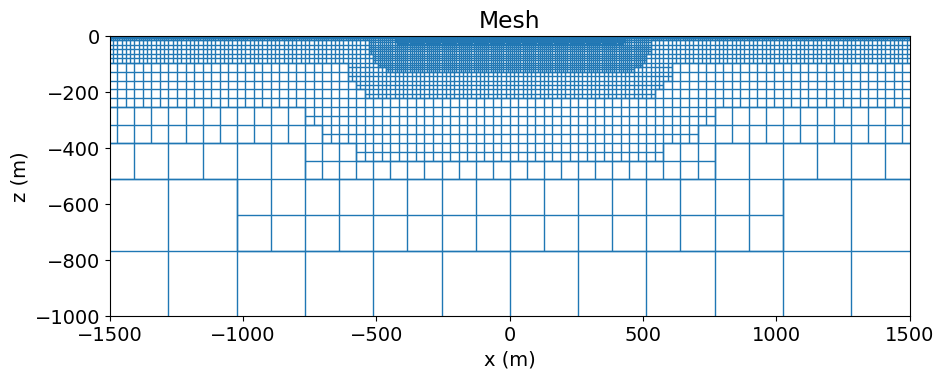

In [6]:
fig = plt.figure(figsize=(10, 4))

ax1 = fig.add_axes([0.14, 0.17, 0.8, 0.7])
mesh.plot_grid(ax=ax1, linewidth=1)
ax1.grid(False)
ax1.set_xlim(-1500, 1500)
ax1.set_ylim(np.max(z_topo) - 1000, np.max(z_topo))
ax1.set_title("Mesh")
ax1.set_xlabel("x (m)")
ax1.set_ylabel("z (m)")

plt.show()

In [7]:
# Indices of the active mesh cells from topography (e.g. cells below surface)
active_cells = active_from_xyz(mesh, topo_2d)

# number of active cells
n_active = np.sum(active_cells)

In [8]:
air_conductivity = 1e-8
background_conductivity = 1e-2
conductor_conductivity = 1e-1
resistor_conductivity = 1e-3

In [9]:
# Define conductivity model
from simpeg.utils import model_builder

conductivity_model = background_conductivity * np.ones(n_active)

ind_conductor = model_builder.get_indices_sphere(
    np.r_[-120.0, -80.0], 60.0, mesh.cell_centers[active_cells, :]
)
conductivity_model[ind_conductor] = conductor_conductivity

ind_resistor = model_builder.get_indices_sphere(
    np.r_[120.0, -80.0], 60.0, mesh.cell_centers[active_cells, :]
)
conductivity_model[ind_resistor] = resistor_conductivity

# Define log-resistivity model
log_resistivity_model = np.log(1 / conductivity_model)

# Conductivity map. Model parameters are conductivities for all active cells.
conductivity_map = maps.InjectActiveCells(mesh, active_cells, air_conductivity)

# Resistivity map. Model parameters are log-resistivities for all active cells.
log_resistivity_map = maps.InjectActiveCells(
    mesh, active_cells, 1 / air_conductivity
) * maps.ExpMap(nP=n_active)

# Generate a mapping to ignore inactice cells in plot
plotting_map = maps.InjectActiveCells(mesh, active_cells, np.nan)

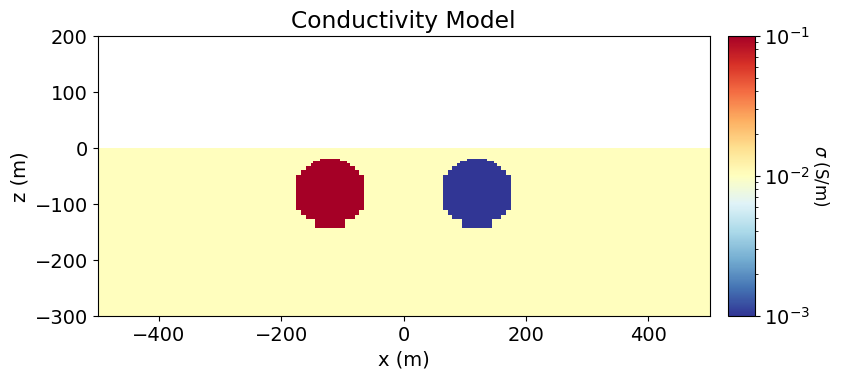

In [10]:
fig = plt.figure(figsize=(9, 4))

norm = LogNorm(vmin=1e-3, vmax=1e-1)

ax1 = fig.add_axes([0.14, 0.17, 0.68, 0.7])
mesh.plot_image(
    plotting_map * conductivity_model,
    ax=ax1,
    grid=False,
    pcolor_opts={"norm": norm, "cmap": mpl.cm.RdYlBu_r},
)
ax1.set_xlim(-500, 500)
ax1.set_ylim(-300, 200)
ax1.set_title("Conductivity Model")
ax1.set_xlabel("x (m)")
ax1.set_ylabel("z (m)")

ax2 = fig.add_axes([0.84, 0.17, 0.03, 0.7])
cbar = mpl.colorbar.ColorbarBase(
    ax2, norm=norm, orientation="vertical", cmap=mpl.cm.RdYlBu_r
)
cbar.set_label(r"$\sigma$ (S/m)", rotation=270, labelpad=15, size=12)

plt.show()

In [11]:
survey.drape_electrodes_on_topography(mesh, active_cells, option="top")

In [12]:
# DC simulation for a conductivity model
simulation_con = dc.simulation_2d.Simulation2DNodal(
    mesh, survey=survey, sigmaMap=conductivity_map
)


In [13]:
dpred_con = simulation_con.dpred(conductivity_model)

/Users/tsuchijo/Documents/DCRMonteCarlo/.venv/lib/python3.12/site-packages/simpeg/base/pde_simulation.py:490: DefaultSolverWarning: Using the default solver: SolverLU. 

If you would like to suppress this notification, add 
warnings.filterwarnings('ignore', simpeg.utils.solver_utils.DefaultSolverWarning)
 to your script.
  return get_default_solver(warn=True)
/Users/tsuchijo/Documents/DCRMonteCarlo/.venv/lib/python3.12/site-packages/pymatsolver/wrappers.py:79: UnusedArgumentWarning: Unused keyword argument "is_symmetric" for splu.
  self.kwargs = kwargs
/Users/tsuchijo/Documents/DCRMonteCarlo/.venv/lib/python3.12/site-packages/pymatsolver/wrappers.py:79: UnusedArgumentWarning: Unused keyword argument "is_positive_definite" for splu.
  self.kwargs = kwargs
/Users/tsuchijo/Documents/DCRMonteCarlo/.venv/lib/python3.12/site-packages/pymatsolver/wrappers.py:81: SparseEfficiencyWarning: splu converted its input to CSC format
  self.solver = fun(self.A, **self.kwargs)
/Users/tsuchijo/Document

Text(0, 0.5, 'Voltage')

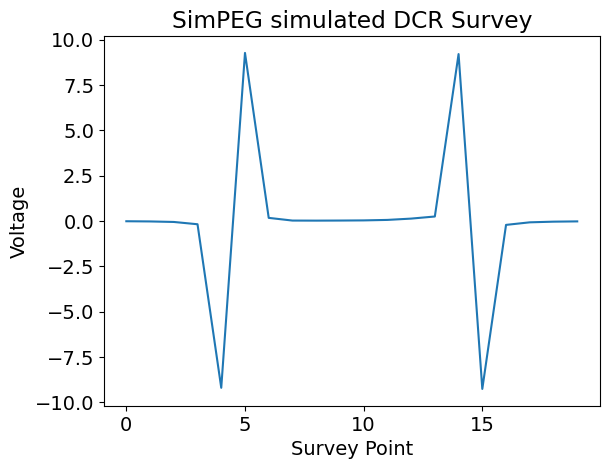

In [14]:
plt.plot(dpred_con)
plt.title("SimPEG simulated DCR Survey")
plt.xlabel("Survey Point")
plt.ylabel("Voltage")

now we build the same model but using the monte carlo method 

In [15]:
def conductivity_field_torch(point):
    """
    Define conductivity field matching testGeophysicalScenario setup.
    """
    x, y = point[0], point[1]
    
    # Background conductivity (1/100 ohm-m)
    background_conductivity = 1e-2
    air_conductivity = 1e-8
    anomaly_center1 = torch.tensor([-120, -80])
    anomaly_center2 = torch.tensor([120, -80])
    anomaly_value1 = (1e-1 - background_conductivity)
    anomaly_value2 = (1e-3 - background_conductivity)
    
    anomaly1 = anomaly_value1 * torch_smooth_circle(point, anomaly_center1, 60)
    anomaly2 = anomaly_value2 * torch_smooth_circle(point, anomaly_center2, 60)

    air =  (air_conductivity - background_conductivity) * torch.sigmoid(10000*y)
    
    # Total conductivity: background + anomalies
    total_conductivity = background_conductivity + anomaly1 + anomaly2 + air
    
    return total_conductivity

def dcr_current_source_torch(point):
    """
    DCR survey current source with positive and negative electrode pair.
    """
    x, y = point[0], point[1]
    
    # Current parameters
    current_amplitude = 1.0
    sigma = 5.0
    
    # Positive electrode at (-10, 0), negative at (10, 0) 
    pos_dist2 = (x + 200.0)**2 + y**2
    neg_dist2 = (x - 200.0)**2 + y**2
    
    # Gaussian approximation for electrode current density
    norm = current_amplitude / (2 * torch.pi * sigma**2)
    
    # Positive source - negative sink
    positive_source = norm * torch.exp(-pos_dist2 / (2 * sigma**2))
    negative_sink = -norm * torch.exp(-neg_dist2 / (2 * sigma**2))
    
    return float(positive_source + negative_sink)

In [28]:
# Domain configuration
domain_size = 1000.0  # 1000m x 1000m survey area
half_size = domain_size / 2.0

# Create Dirichlet boundary (bottom and sides, excluding top surface)
dirichlet_points = torch.tensor([
    [-half_size, 1],  # top left
    [-half_size, -domain_size],   # Bottom right
    [half_size, -domain_size],   # Bottom right
    [half_size,1],   # Bottom right
])



# Create Neumann boundary (top surface only)
neumann_points = torch.tensor([
    [half_size,1],   # Bottom right
    [-half_size, 1]     # Top left
])

# Create boundary geometries
dirichlet_boundary = PolyLinesSimple(dirichlet_points)
neumann_boundary = PolyLinesSimple(neumann_points)

# measurement electrodes

In [34]:
# Initialize solver
print("Initializing WoS solver...")
solver = WostSolver_2D(
    dirichletBoundary=dirichlet_boundary,
    neumannBoundary=neumann_boundary,
    dirichletBoundaryFunction=lambda p: 0.0,
    source=dcr_current_source_torch,
    alpha=conductivity_field_torch,  # Conductivity field
    sigma=None  # No absorption for DC resistivity
)

# TODO: Fix neumann boundaries, the walk appears to be escaping

print("Running DCR survey simulation...")
n_walks = 250  # Reduced for testing
max_steps = 500

electrode_x = torch.tensor(electrode_locations_x)
electrode_y = torch.zeros_like(electrode_x) - 0.1

measurement_electrodes = torch.stack([electrode_x, electrode_y], dim=1)


voltages, history = solver.solve(
    measurement_electrodes[1:2],
    nWalks=n_walks,
    maxSteps=max_steps,
    eps = 0.9,
    return_history=True
)

voltages

Initializing WoS solver...
Running DCR survey simulation...


Solving WoS Delta (Unified):   0%|          | 0/1 [00:13<?, ?pt/s]
/Users/tsuchijo/Documents/DCRMonteCarlo/solvers/WoStSolver.py:92: SyntaxWarning: invalid escape sequence '\s'
  $$\sigma = \frac{\sigma(x)}{\alpha(x)} + \frac{1}{2}(\frac{\laplaca\alpha(x)}{\alpha(x)} - \frac{|\nabla ln(\alpha(x))|^2}{2})$$


KeyboardInterrupt: 

In [51]:
from utils import plot_walk_history
plot_walk_history(history)

ImportError: cannot import name 'plot_walk_history' from 'utils' (/Users/tsuchijo/Documents/DCRMonteCarlo/utils.py)

Text(0, 0.5, 'Voltage')

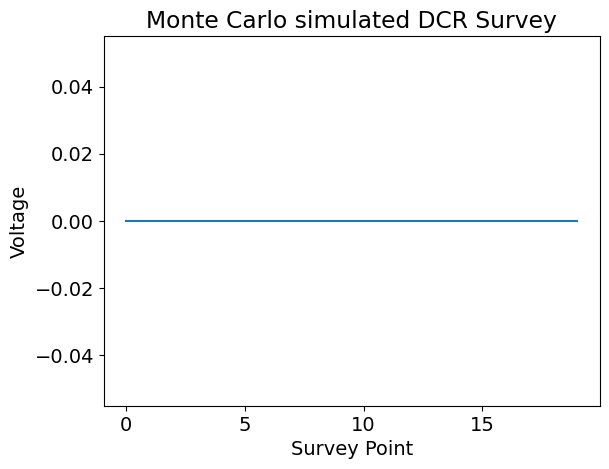

In [19]:
voltages = voltages.detach()
plt.plot(voltages[:-1] - voltages[1:])
plt.title("Monte Carlo simulated DCR Survey")
plt.xlabel("Survey Point")
plt.ylabel("Voltage")